## Use this Notebook to Generate the Plots 

In [29]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
from sklearn.metrics import f1_score,recall_score, precision_score


In [30]:
# function to make a df from the predictions for all noise values for a given setup
def get_pred_df(root_dir, LABEL="sentiment"):
    dfs = []    
    seed = root_dir.split("-")[-1]
    subdirs = [f for f in os.listdir(root_dir)]
    subdirs
    for split in ["train", "val"]:
        for dir in subdirs:
            # print(dir)
            
            match = re.search(f'{LABEL}-noise-(\d+\.\d+)', dir)
            if match:
                noise_ratio = float(match.group(1))
                # print("Sentiment Value:", noise_ratio)
            else:
                print("No sentiment value found.")

            df = pd.read_csv(os.path.join(root_dir, dir, f"{split}_preds.csv"))
            df["noise_ratio"] = noise_ratio
            df["split"] = split
            df["seed"] = seed
            dfs.append(df)

    pred_df = pd.concat(dfs)
    return pred_df

In [31]:
def get_f1_df(pred_df, epochs=20):

    epochs = []
    f1s = []
    noises = []
    splits = []
    for i in range(0, 20):
        for noise in [0.0, 0.1, 0.2, 0.3, 0.4]:
            for split in ["train", "val"]:
                epochs.append(i)
                noises.append(noise)
                splits.append(split)
                if i == 0:
                    f1s.append(0)
                else:
                    df = pred_df[pred_df["noise_ratio"] == noise]   
                    df = df[df["split"] == split]
                    f1 = f1_score(df["label"], df[f"pred_{i}"], average="binary")
                    f1s.append(f1)
                    # print("noise", noise, "split", split, "epoch", i, "f1", f1)
    
    data = {'epochs': epochs, 'f1s': f1s, "noise":noises, "split":splits}
    df = pd.DataFrame(data) 
    return df

# F1 Scores

Effect of Balance - Control Data Size

In [32]:
experiment_dir_root = "../../../naacl-noise/low-res-noise/experiments/"

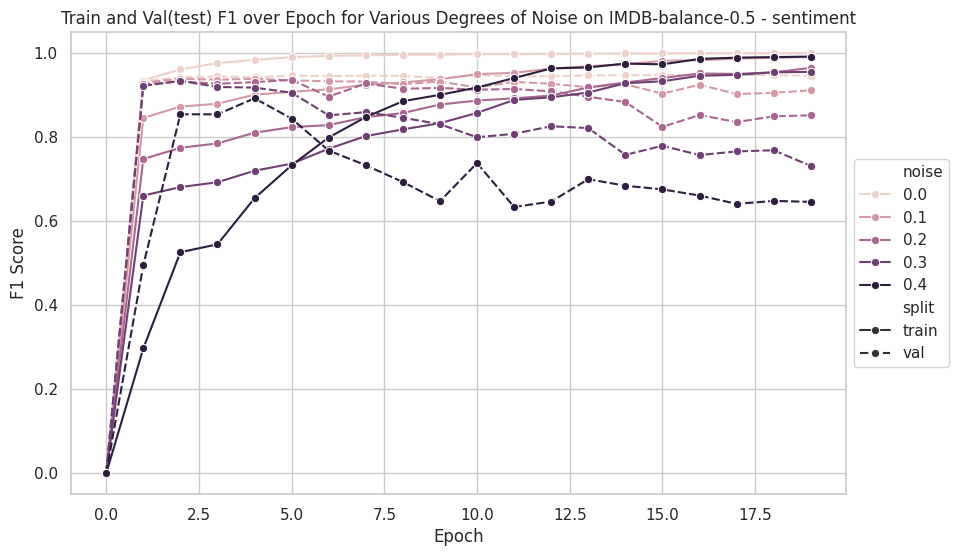

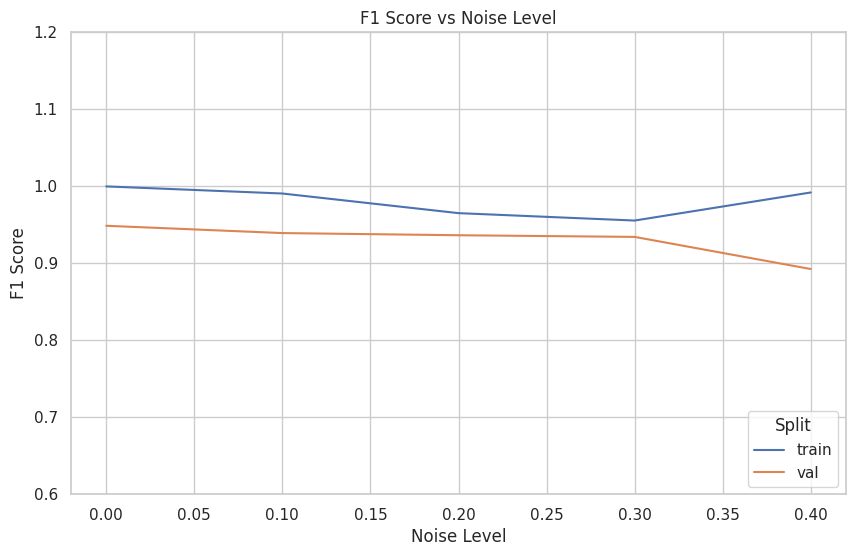

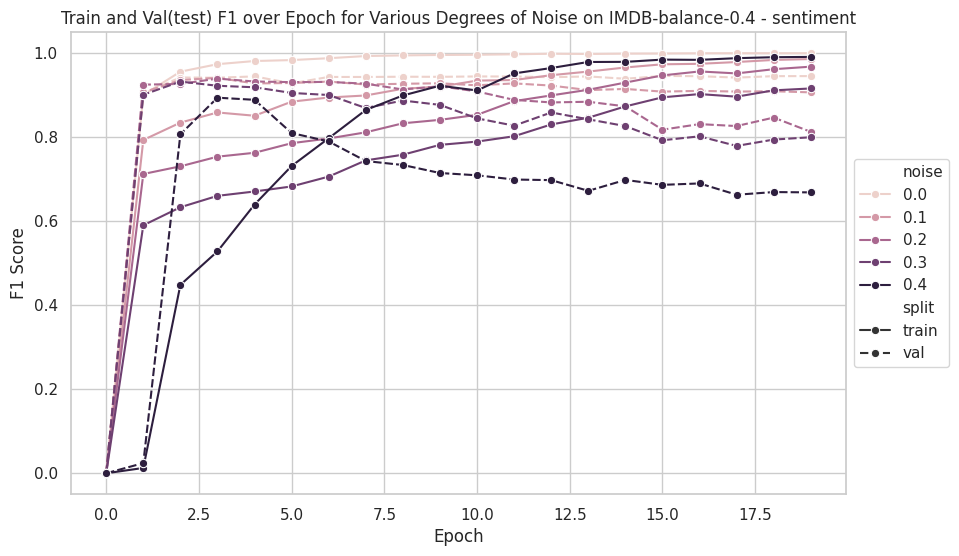

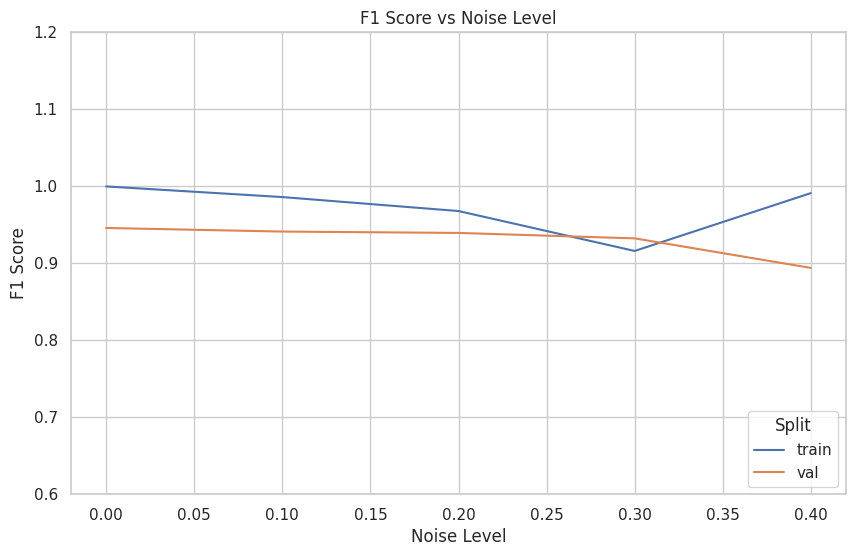

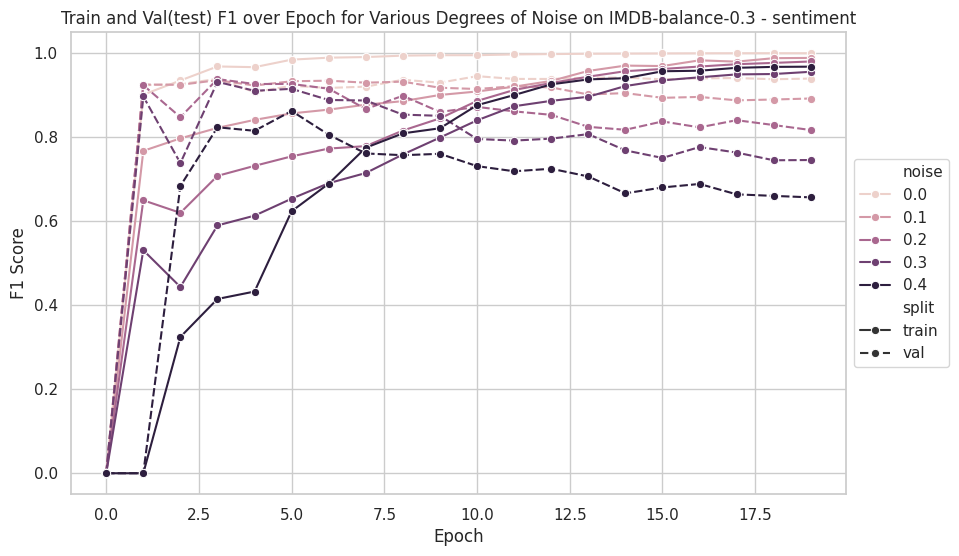

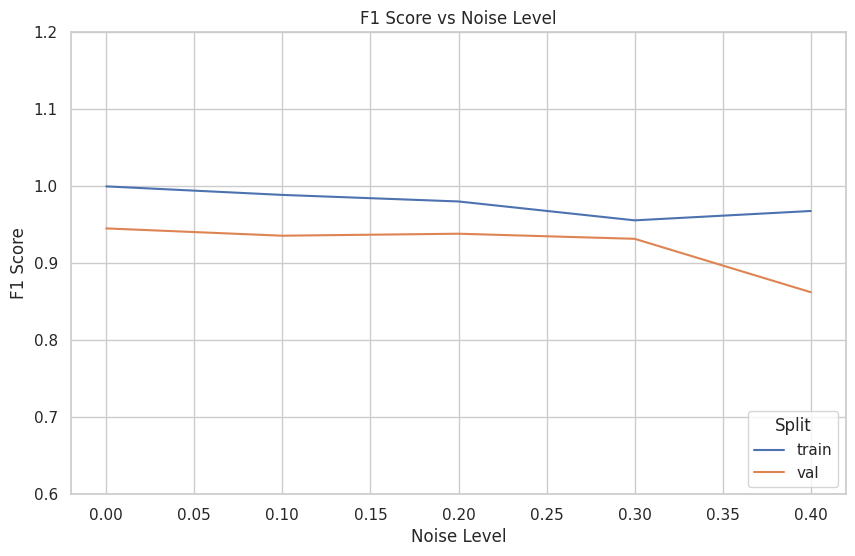

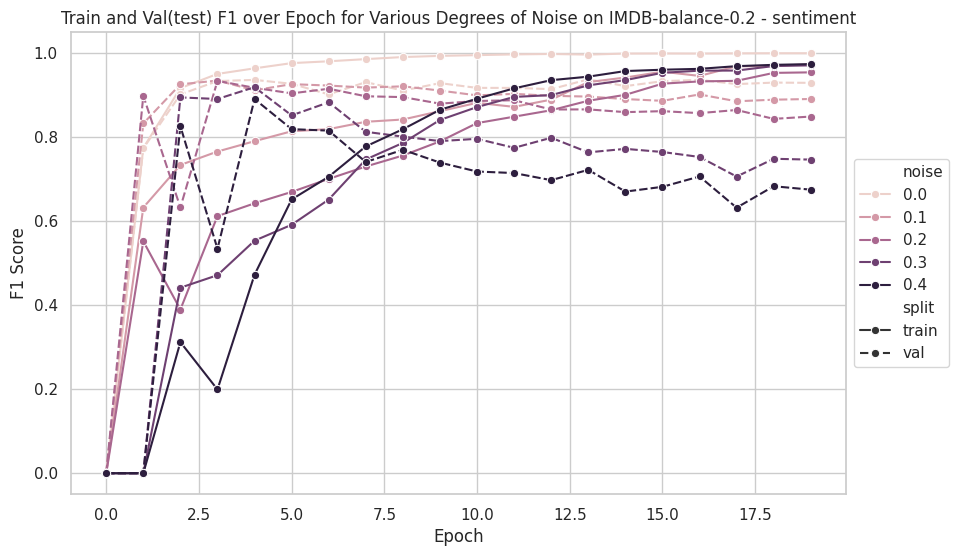

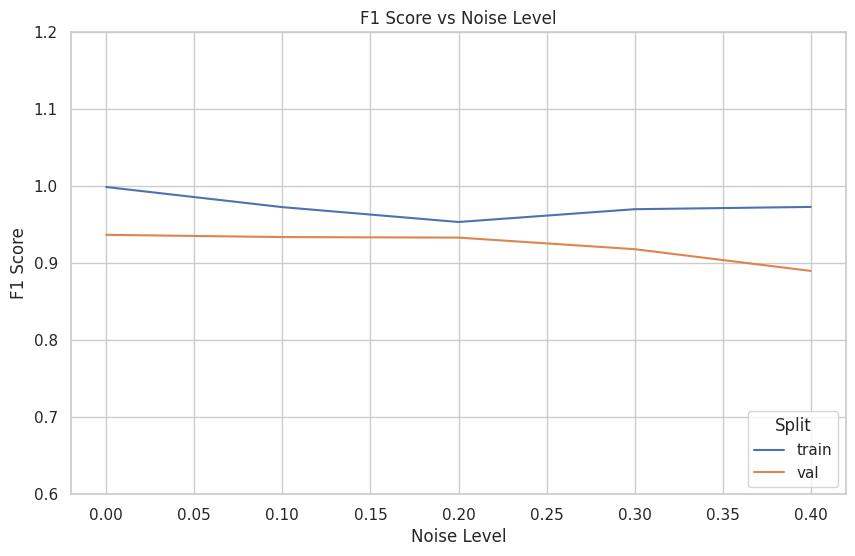

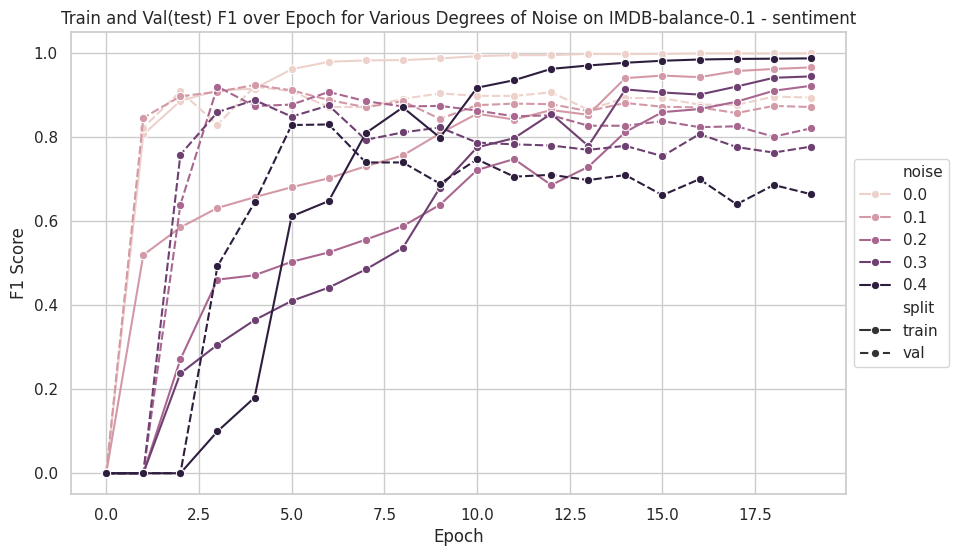

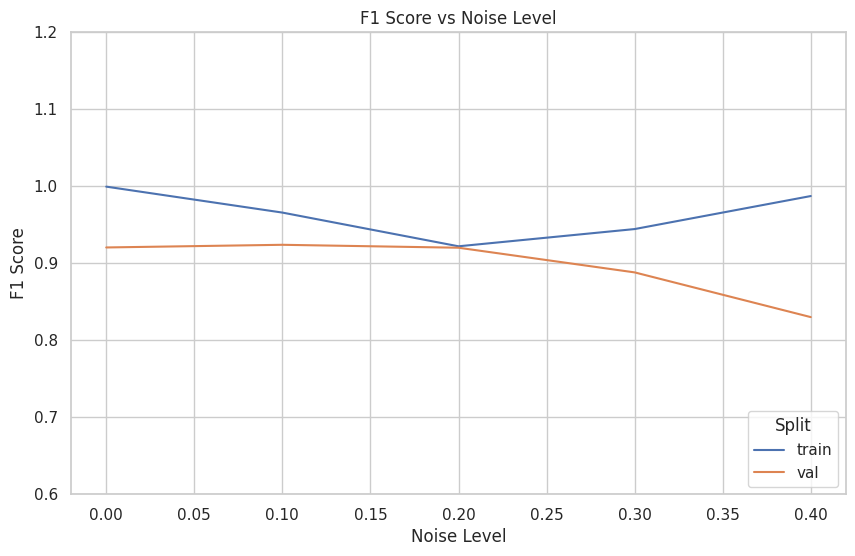

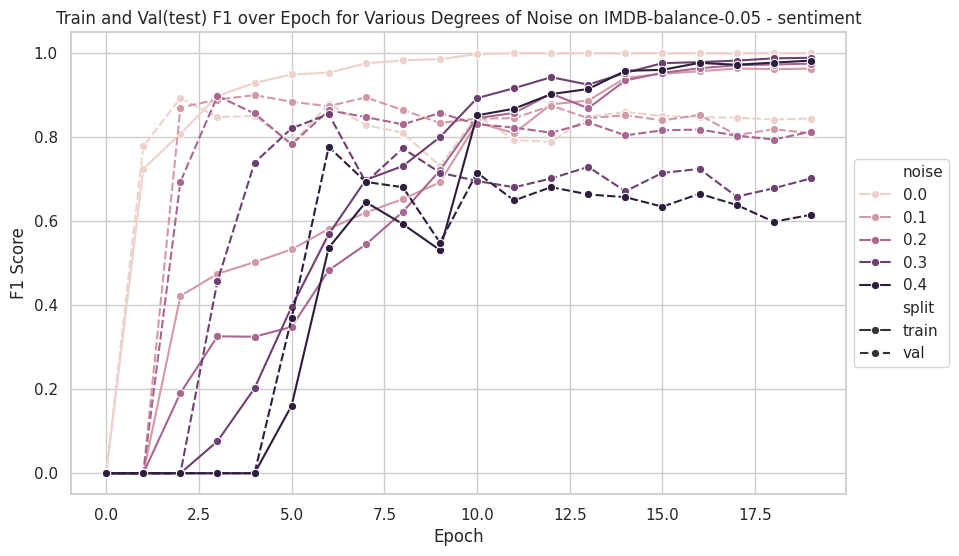

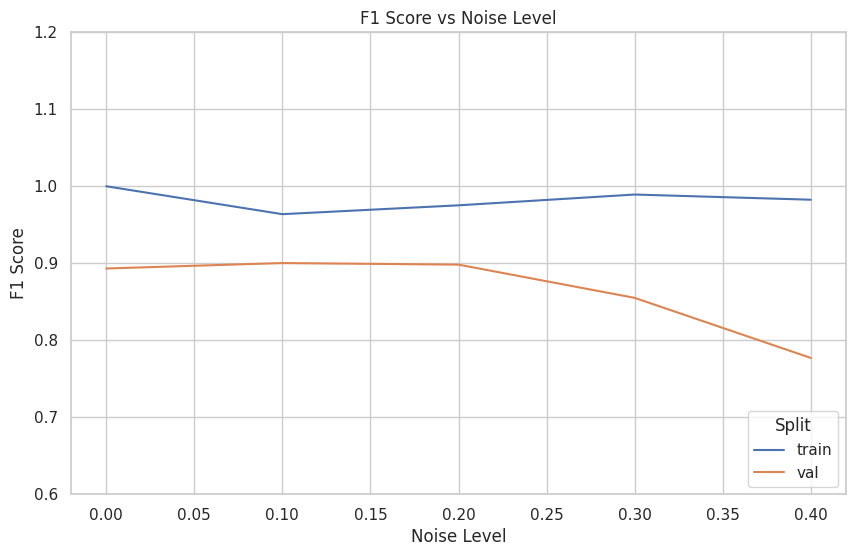

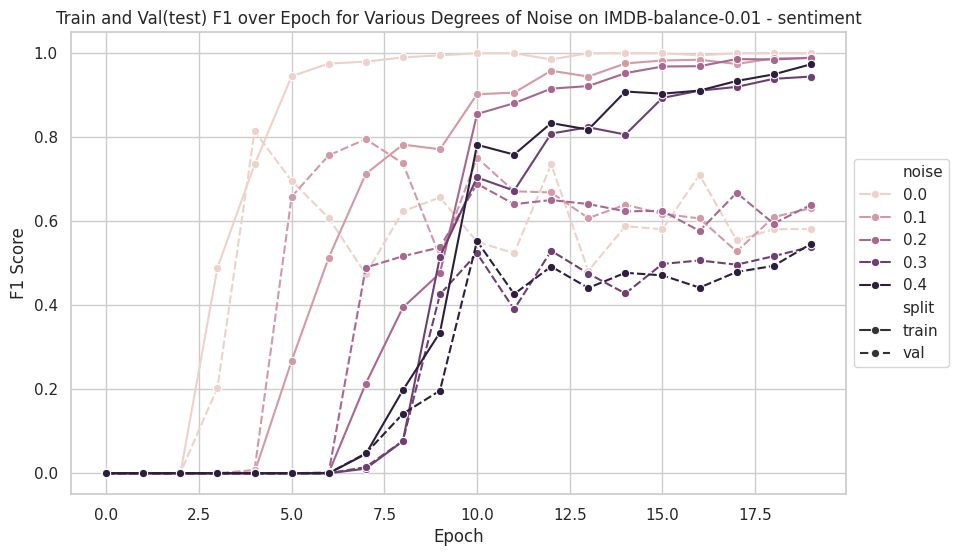

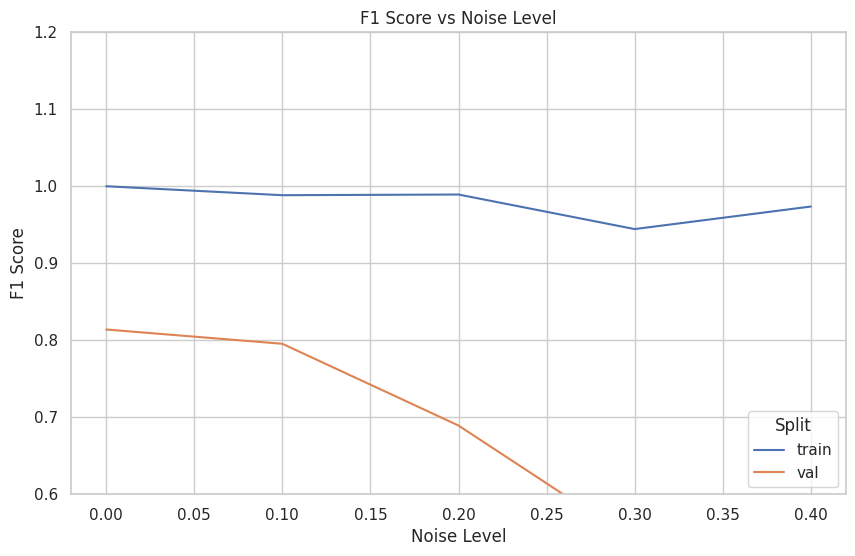

In [34]:
LABEL = "sentiment"
BALANCE = 0.5
EPOCHS = 20
limit = 10000
l2 =0.01
method="finetune"
max_dfs = []
for balance in [0.5, 0.4, 0.3,0.2,0.1, 0.05, 0.01]:
    root_dir = os.path.join(experiment_dir_root, f"acl-exp5-method-{method}-limit-{limit}-l2-{l2}-balance-{balance}")
    DATASET = f"IMDB-balance-{balance}"
    pred_df = get_pred_df(root_dir)
    f1_df = get_f1_df(pred_df, epochs=EPOCHS)
    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))
    sns.lineplot(x='epochs', y='f1s', hue='noise', style="split", data=f1_df, marker='o')

    # Set plot title and labels
    plt.title(f'Train and Val(test) F1 over Epoch for Various Degrees of Noise on {DATASET} - {LABEL}')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')

    # Show the plot
    plt.show()
    max_df = f1_df.groupby([ "noise", "split"]).max()

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    max_df["balance"] = balance
    max_dfs.append(max_df.reset_index())
    # You can choose different styles of plots depending on your preference
    sns.lineplot(x=max_df.index.get_level_values('noise'), y='f1s', hue='split', data=max_df.reset_index(), markers=True)
    plt.ylim(0.6, 1.2)
    plt.title('F1 Score vs Noise Level')
    plt.xlabel('Noise Level')
    plt.ylabel('F1 Score')
    plt.legend(title='Split', loc='lower right')


# 

In [35]:
max_df = pd.concat(max_dfs)
max_df

,noise,split,epochs,f1s,balance
0,0.0,train,19,0.999800,0.50
1,0.0,val,19,0.948661,0.50
2,0.1,train,19,0.990570,0.50
3,0.1,val,19,0.939194,0.50
4,0.2,train,19,0.965083,0.50
...,...,...,...,...,...
5,0.2,val,19,0.689249,0.01
6,0.3,train,19,0.944389,0.01
7,0.3,val,19,0.539040,0.01
8,0.4,train,19,0.973648,0.01


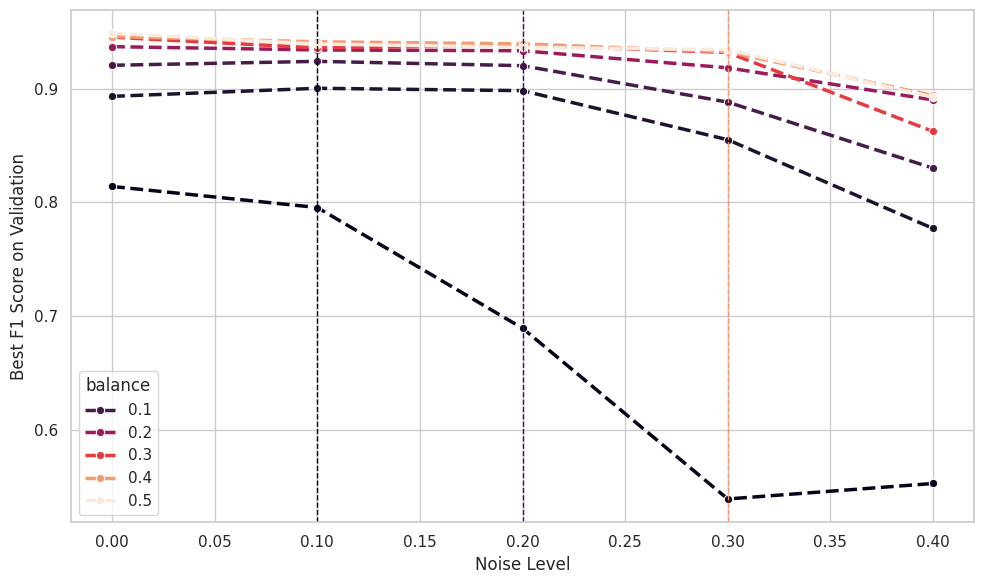

In [41]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))


sns.lineplot(palette="rocket", x="noise", y='f1s', hue='balance', data=max_df[max_df.split=="val"], marker="o", markers=True, linewidth=2.5, linestyle="--")
plt.xlabel('Noise Level')
plt.ylabel('Best F1 Score on Validation')
plt.axvline(x=0.1, color="black", linestyle='--', linewidth=1)
plt.axvline(x=0.2, color="Indigo", linestyle='--', linewidth=1)
plt.axvline(x=0.3, color=sns.color_palette("rocket", 8)[6], linestyle='--', linewidth=1)
plt.legend(title="balance", loc='best')
plt.tight_layout()
plt.savefig('imbalance_robustness.png', dpi=300)  # Set DPI to 300 for high quality


# Learned

In [42]:
epochs = []
learned_so_far = []
learned_this_epoch = []
forgotten_this_epoch = []
forgotten_so_far = []
splits = []
noise_ratios = []
EPOCHS = 20
for split in ["train", "val"]:
    for noise in [0.0, 0.1, 0.2, 0.3, 0.4]:

        split_df = pred_df[(pred_df["split"] == split) & (pred_df["noise_ratio"] == noise)]
        total_learned = [False]*len(split_df)
        total_forgotten = [False]*len(split_df)

        for i in range(1, EPOCHS+1):
            epochs.append(i)
            splits.append(split)
            noise_ratios.append(noise)
            cur_learned = list(split_df[f"pred_{i}"] == split_df["label"])
            total_learned = [x or y for x, y in zip(total_learned, cur_learned)]
            learned_so_far.append(sum(total_learned))
            if i == 1:
                learned_this_epoch.append(sum(cur_learned))
                forgotten_this_epoch.append(0)
                forgotten_so_far.append(0)
            else:
                learned_this_epoch.append(learned_so_far[-1] - learned_so_far[-2])
                cur_forgotten = list((split_df[f"pred_{i-1}"] == split_df["label"]) & (split_df[f"pred_{i}"] != split_df["label"]))
                forgotten_this_epoch.append(sum(cur_forgotten))
                total_forgotten = [x or y for x, y in zip(total_forgotten, cur_forgotten)]
                forgotten_so_far.append(sum(total_forgotten))
        

In [43]:
df = pd.DataFrame({"noise":noise_ratios, 'epochs': epochs, 'forgotten_so_far':forgotten_so_far, 'learned_so_far': learned_so_far, 'learned_this_epoch': learned_this_epoch, 'forgotten_this_epoch': forgotten_this_epoch, "split":splits})
total_train = len(pred_df[(pred_df["split"] == "train") & (pred_df["noise_ratio"] == 0.0)])
total_val = len(pred_df[(pred_df["split"] == "val") & (pred_df["noise_ratio"] == 0.0)])
df

,noise,epochs,forgotten_so_far,learned_so_far,learned_this_epoch,forgotten_this_epoch,split
0,0.0,1,0,9900,9900,0,train
1,0.0,2,0,9900,0,0,train
2,0.0,3,5,9934,34,5,train
3,0.0,4,60,9993,59,55,train
4,0.0,5,60,9995,2,0,train
...,...,...,...,...,...,...,...
195,0.4,16,1258,3041,3,116,val
196,0.4,17,1272,3052,11,76,val
197,0.4,18,1281,3054,2,47,val
198,0.4,19,1321,3103,49,152,val


In [44]:

N_fs = []
N_ls = []
noises = []
splits = []
for noise in [0.1, 0.2, 0.3, 0.4]:
    for split in ["train", "val"]:
        N_forgotten = df[(df["epochs"]==EPOCHS) & (df["split"] == split)& (df["noise"]==noise)]["forgotten_so_far"].values[0]
        N_learned = df[(df["epochs"]==10) & (df["split"] == split) & (df["noise"]==noise)]["learned_so_far"].values[0]
        print(f"noise {noise} split {split} forgotten {N_forgotten} learned {N_learned} forgotten/learned {N_forgotten/N_learned}")
        N_fs.append(N_forgotten)
        N_ls.append(N_learned)
        noises.append(noise)
        splits.append(split)

learned_df = pd.DataFrame({"noise":noises, "split":splits, "N_forgotten":N_fs, "N_learned":N_ls})


noise 0.1 split train forgotten 452 learned 9840 forgotten/learned 0.0459349593495935
noise 0.1 split val forgotten 1074 learned 3461 forgotten/learned 0.31031493787922565
noise 0.2 split train forgotten 506 learned 9604 forgotten/learned 0.05268638067471887
noise 0.2 split val forgotten 785 learned 3144 forgotten/learned 0.2496819338422392
noise 0.3 split train forgotten 1810 learned 9093 forgotten/learned 0.1990542175299681
noise 0.3 split val forgotten 1255 learned 2906 forgotten/learned 0.4318651066758431
noise 0.4 split train forgotten 1625 learned 8915 forgotten/learned 0.18227706113292205
noise 0.4 split val forgotten 1363 learned 2977 forgotten/learned 0.457843466577091


In [45]:
plot_df

,noise,split,N_forgotten,N_learned,method
0,0.1,train,452,9840,LoRA
1,0.1,val,1074,3461,LoRA
2,0.2,train,506,9604,LoRA
3,0.2,val,785,3144,LoRA
4,0.3,train,1810,9093,LoRA
5,0.3,val,1255,2906,LoRA
6,0.4,train,1625,8915,LoRA
7,0.4,val,1363,2977,LoRA


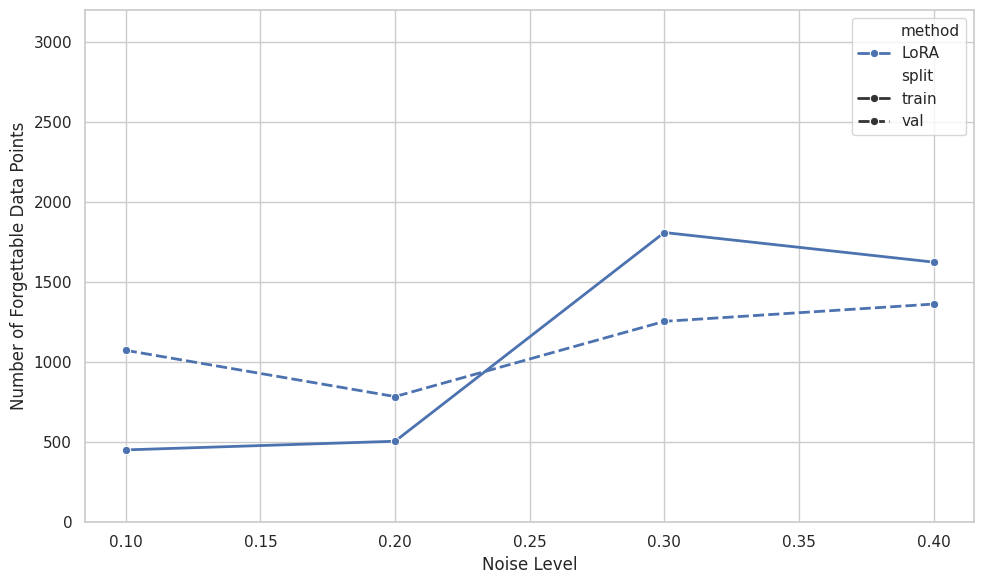

: 

In [57]:
try:
    learned_df["method"]="LoRA"
    forgotten_dfs.append(learned_df)
    plot_df = pd.concat(forgotten_dfs)
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='noise', y='N_forgotten', style='split', hue="method", data=plot_df, marker='o', linewidth=2)
    plt.ylim(0, 3200)
    handles, labels = plt.gca().get_legend_handles_labels()
    labels[0]= "Method"
    labels[3] = "Split"
    plt.legend( handles, labels, loc='upper left', ncol=2)
    plt.ylabel("Number of Forgettable Data Points")
    plt.xlabel("Noise Level")
    plt.tight_layout()
    plt.savefig('forgettable_new.png', dpi=300, bbox_inches='tight')  # Set DPI to 300 for high quality
except:
    break
    plot_df = learned_df
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='noise', y='N_forgotten', style='split', hue="method", data=plot_df, marker='o', linewidth=2)
    plt.ylim(0, 3200)
    plt.ylabel("Number of Forgettable Data Points")
    plt.xlabel("Noise Level")
    plt.tight_layout()
    plt.savefig('forgettable_new.png', dpi=300, bbox_inches='tight')  # Set DPI to 300 for high quality


Text(0.5, 1.0, 'Number of Total Learned (incl forgotten) through Epochs on IMDB-balance-0.01 - sentiment')

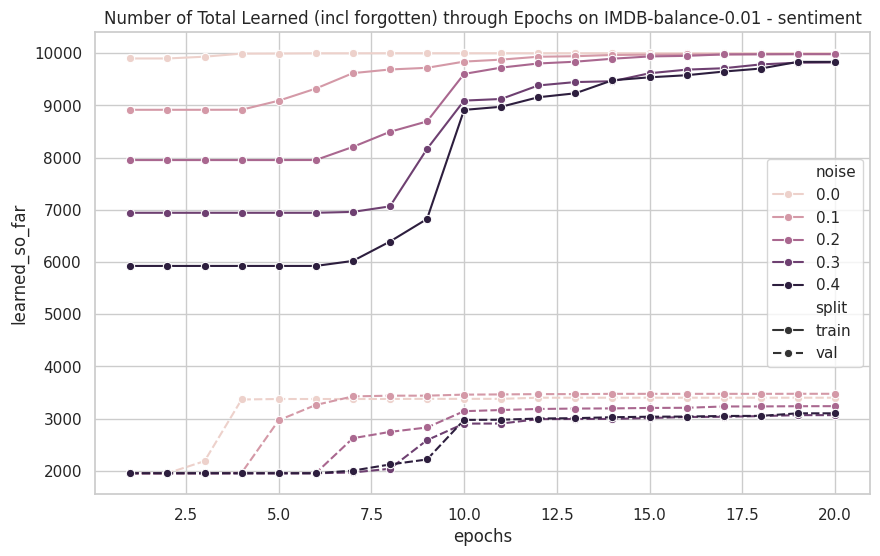

In [47]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="epochs", y="learned_so_far", hue="noise", style="split", marker='o')
plt.title(f"Number of Total Learned (incl forgotten) through Epochs on {DATASET} - {LABEL}")

NameError: name 'LM' is not defined

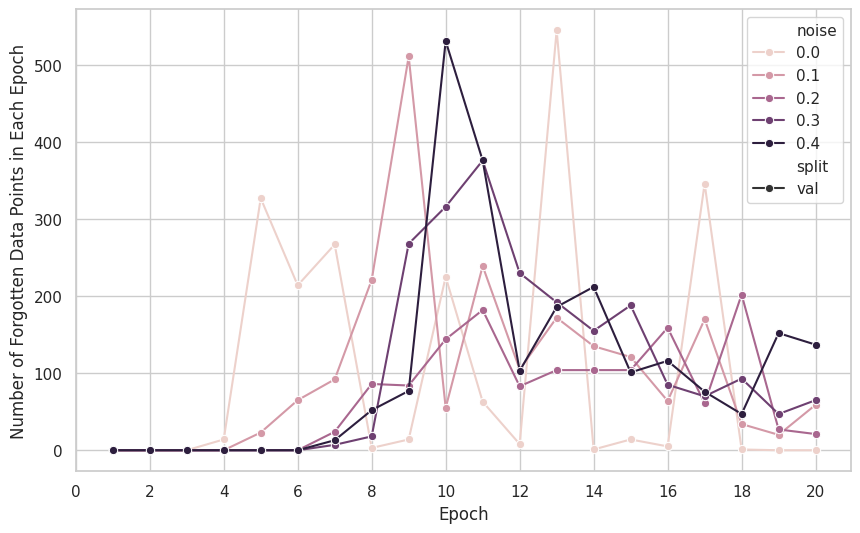

In [48]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df[df.split=="val"], x="epochs", y="forgotten_this_epoch", hue="noise", style="split", marker='o')
# plt.title(f"Number of Forgotten Data Points in Each epoch {DATASET} - {LABEL}")
plt.xticks(range(0, EPOCHS+1, 2))
plt.xlabel('Epoch')
plt.ylabel('Number of Forgotten Data Points in Each Epoch')
plt.savefig(f'{LM}_forgotten_data_each_epoch_plot.png', dpi=300, bbox_inches='tight')

NameError: name 'LM' is not defined

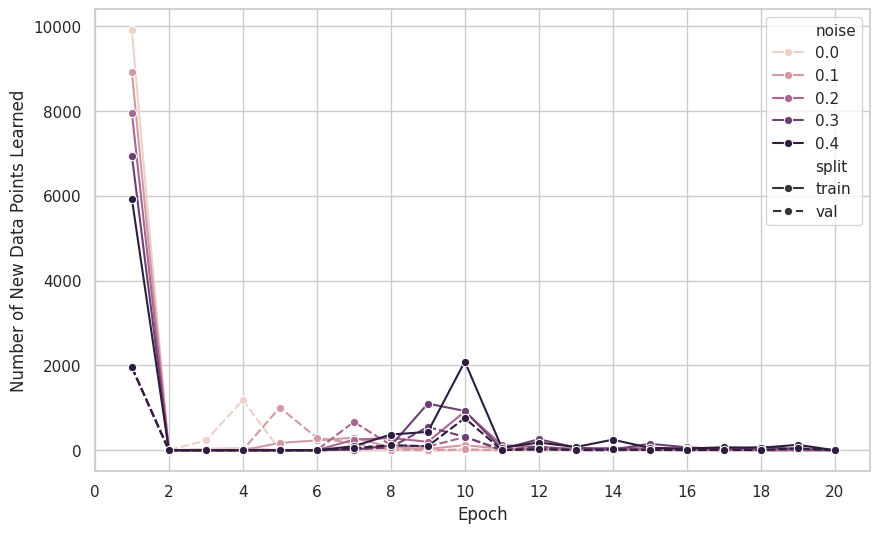

In [49]:
# this counts learning of each data point only once
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="epochs", y="learned_this_epoch", hue="noise", style="split", marker='o')
# plt.title("Number of New Data Points Learned in Each epoch")
plt.ylabel("Number of New Data Points Learned")
plt.xticks(range(0, df['epochs'].max()+1, 2))
plt.xlabel('Epoch')
plt.savefig(f'{LM}_newly_learned_data_points_plot.png', dpi=300, bbox_inches='tight')

# Learning over Noisy and Clean

In [50]:
balance = 0.5
root_dir = os.path.join(experiment_dir_root, f"acl-exp5-method-{method}-limit-{limit}-l2-{l2}-balance-{balance}")
DATASET = f"IMDB-balance-{balance}"
pred_df = get_pred_df(root_dir)
pred_df["balance"] = balance
    # break
    # f1_df = get_f1_df(pred_df, epochs=EPOCHS)



In [51]:
pred_df

FILTER_CLEAN = False
FILTER_NOISY = False
if FILTER_CLEAN:
    pred_df = pred_df[pred_df["label_flipped"]==False]

if FILTER_NOISY:
    pred_df = pred_df[pred_df["label_flipped"]==True]

# forgotten_dfs = []


In [52]:
pred_df

,id,label_flipped,label,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,...,pred_15,pred_16,pred_17,pred_18,pred_19,pred_20,noise_ratio,split,seed,balance
0,13559,False,0,0,0,0,1,0,1,1,...,1,1,0,0,0,0,0.5,train,0.5,0.5
1,26091,True,1,0,0,0,1,1,1,1,...,1,1,1,1,1,1,0.5,train,0.5,0.5
2,24874,False,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0.5,train,0.5,0.5
3,29759,False,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0.5,train,0.5,0.5
4,1229,False,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0.5,train,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3995,False,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0.1,val,0.5,0.5
3996,3996,False,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.1,val,0.5,0.5
3997,3997,False,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0.1,val,0.5,0.5
3998,3998,False,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0.1,val,0.5,0.5


<Axes: xlabel='epoch', ylabel='correct_clean_to_total_ratio'>

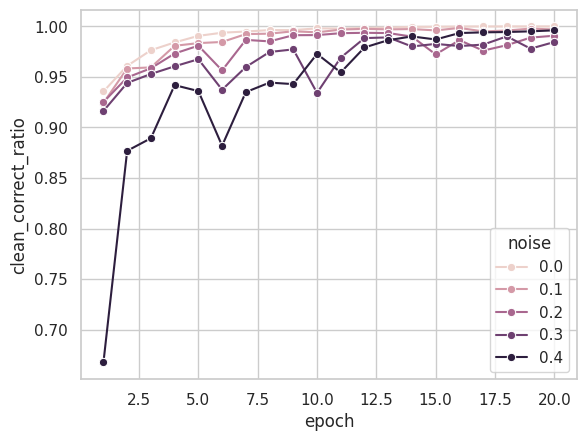

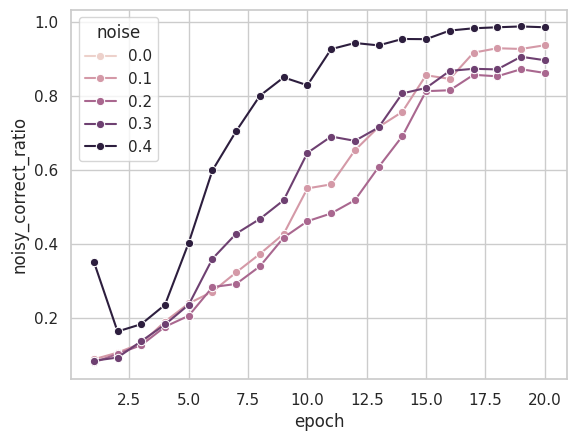

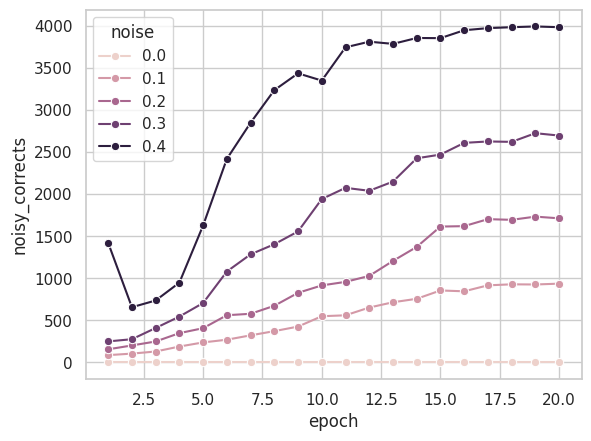

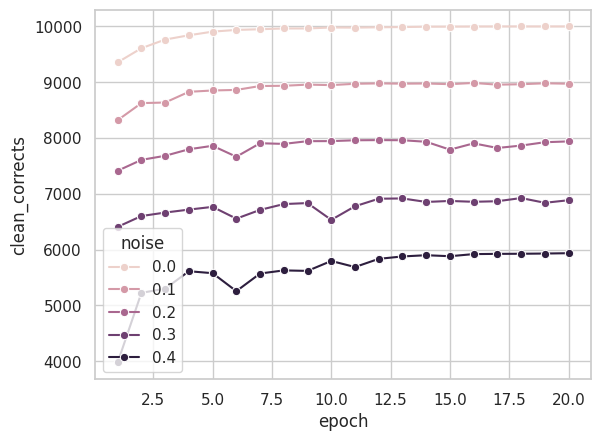

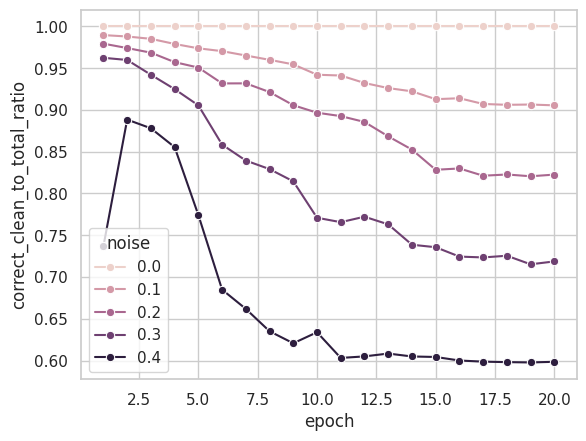

In [53]:
balance_df = pred_df[pred_df["balance"]==0.5]

clean_corrects = []
noises = []
epochs = []
total_clean = []
total_noisy = []
noisy_corrects =[]
for noise in [0.0, 0.1, 0.2, 0.3, 0.4]:
    for split in ["train"]:
        for i in range(1,EPOCHS+1):
            noises.append(noise)
            epochs.append(i)
            df = balance_df[balance_df["noise_ratio"] == noise]   
            split_df = df[df["split"] == split]
            clean_corrects.append(len((split_df[(split_df[f"pred_{i}"] == split_df["label"]) & (split_df["label_flipped"]==False)])))
            noisy_corrects.append(len((split_df[(split_df[f"pred_{i}"] == split_df["label"]) & (split_df["label_flipped"]==True)])))
            total_clean.append(len((split_df[(split_df["label_flipped"]==False)])))
            total_noisy.append(len((split_df[(split_df["label_flipped"]==True)])))

df = pd.DataFrame({"clean_corrects":clean_corrects, "noise":noises, "epoch":epochs, "total_clean":total_clean, "total_noisy":total_noisy, "noisy_corrects":noisy_corrects})
df["clean_correct_ratio"]=df["clean_corrects"]/df["total_clean"]
df["noisy_correct_ratio"]=df["noisy_corrects"]/df["total_noisy"]
sns.lineplot(x='epoch', y='clean_correct_ratio', hue='noise', data=df, marker='o')
plt.figure()
sns.lineplot(x='epoch', y='noisy_correct_ratio', hue='noise', data=df, marker='o')
plt.figure()
sns.lineplot(x='epoch', y='noisy_corrects', hue='noise', data=df, marker='o')
plt.figure()
sns.lineplot(x='epoch', y='clean_corrects', hue='noise', data=df, marker='o')
            
df["correct_clean_to_total_ratio"] = df["clean_corrects"]/(df["noisy_corrects"]+ df["clean_corrects"])
plt.figure()
sns.lineplot(x='epoch', y='correct_clean_to_total_ratio', hue='noise', data=df, marker='o')

NameError: name 'LM' is not defined

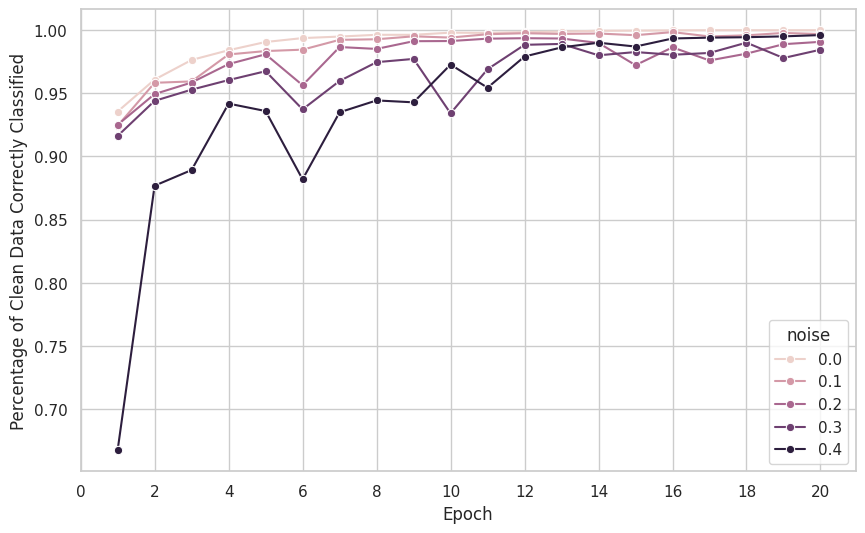

In [44]:

plt.figure(figsize=(10, 6))
sns.lineplot(x='epoch', y='clean_correct_ratio', hue='noise', data=df, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Percentage of Clean Data Correctly Classified')
plt.xticks(range(0, df['epoch'].max()+1, 2))
plt.savefig(f"{LM}_clean_training_accuracy_plot.png", dpi=300, bbox_inches='tight')

NameError: name 'LM' is not defined

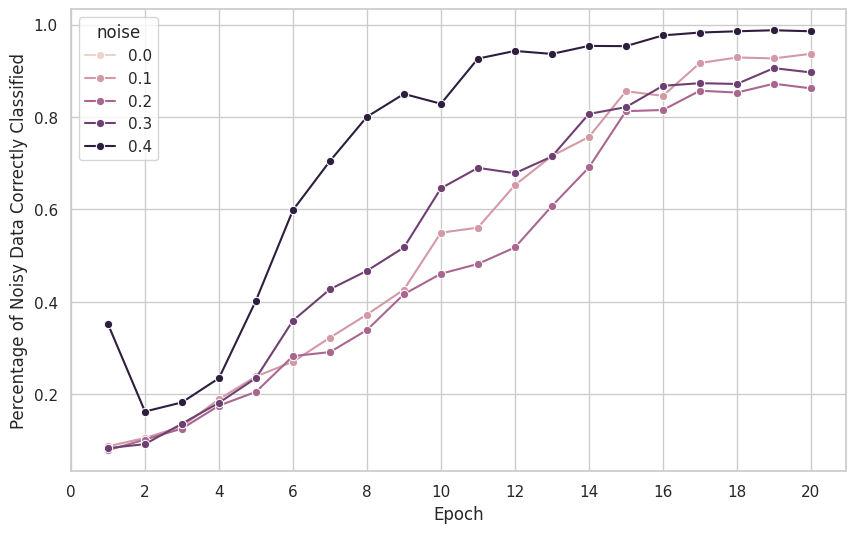

In [45]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='epoch', y='noisy_correct_ratio', hue='noise', data=df, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Percentage of Noisy Data Correctly Classified')
plt.xticks(range(0, df['epoch'].max()+1, 2))
plt.savefig(f"{LM}_noisy_training_accuracy_plot.png", dpi=300, bbox_inches='tight')